In [27]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob

In [ ]:
# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="DVD Rentals",
    user="postgres",
    password="zamzam",
    host="localhost",
    port="5432"
)

In [70]:
# Query the data for payments
query1 = """
    SELECT p.payment_date, c.country, p.amount
    FROM payment p
    JOIN customer cu ON p.customer_id = cu.customer_id
    JOIN address a ON cu.address_id = a.address_id
    JOIN city ci ON a.city_id = ci.city_id
    JOIN country c ON ci.country_id = c.country_id
"""

df1 = pd.read_sql_query(query1, conn)
df1['payment_date_dt']=df1['payment_date'].dt.date

C:\Users\ziadh\AppData\Local\Temp\ipykernel_300\574525127.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_of_colors)


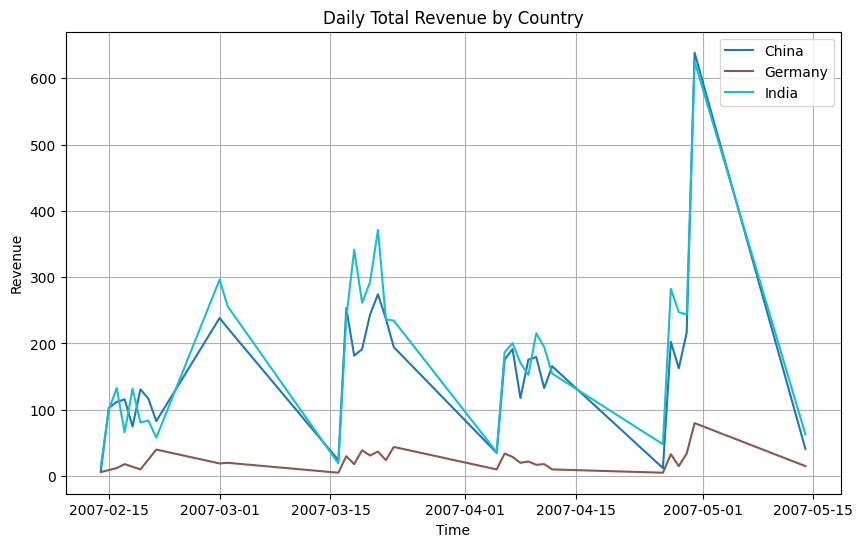

In [75]:
# Aggregating the payment data by country, payment date, and summing the amounts
df1 = df1.groupby(['payment_date_dt', 'country'])['amount'].sum().reset_index()

# Pivot the data
pivoted_data = df1.pivot(index='payment_date_dt', columns='country', values='amount')

# All unique countries
all_countries = df1['country'].unique()


selected_countries = df1.groupby('country').count().nlargest(3, 'payment_date_dt').reset_index()
num_of_colors = len(selected_countries)
colors = plt.cm.get_cmap('tab10', num_of_colors)
plot = pivoted_data.reset_index()

# Plot the time-series
plt.figure(figsize=(10, 6))
for idx, row in selected_countries.iterrows():
    country = row['country']
    plt.plot(plot['payment_date_dt'], plot[country], label=country, color=colors(idx))
plt.title('Daily Total Revenue by Country')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Question 2

query2 = """
    SELECT film_id, description
    FROM film
"""

df2 = pd.read_sql_query(query2, conn)

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df2['sentiment'] = df['description'].apply(get_sentiment)

In [79]:
# Adding sentiments to the dataframe

for i in range(0, len(df2['sentiment'])):
    if df2['sentiment'][i] == 0:
        df2.loc[i, 'major_sentiment'] = 'Neutral'
    elif df2['sentiment'][i] > 0:
        df2.loc[i, 'major_sentiment'] ='Positive'
    elif df2['sentiment'][i] < 0:
        df2.loc[i, 'major_sentiment'] = 'Negative'
        
#Display dataframe

df2

,film_id,description,sentiment,major_sentiment
0,133,A Fateful Reflection of a Moose And a Husband ...,-0.0500,Negative
1,384,A Epic Drama of a Cat And a Explorer who must ...,0.1000,Positive
2,8,A Epic Tale of a Moose And a Girl who must Con...,0.0250,Positive
3,98,A Fateful Yarn of a Lumberjack And a Feminist ...,-0.1000,Negative
4,1,A Epic Drama of a Feminist And a Mad Scientist...,-0.2625,Negative
...,...,...,...,...
995,996,A Unbelieveable Yarn of a Boat And a Database ...,0.0750,Positive
996,997,A Touching Drama of a Teacher And a Cat who mu...,0.2500,Positive
997,998,A Fateful Yarn of a Composer And a Man who mus...,-0.1000,Negative
998,999,A Fateful Reflection of a Waitress And a Boat ...,0.0000,Neutral


In [ ]:
# Question 3

query3 = """
    SELECT
    co.country_id,
    co.country,
    COUNT(c.customer_id) AS customer_count,
    SUM(p.amount) AS total_revenue
FROM
    customer c
JOIN
    address a ON c.address_id = a.address_id
JOIN
    city ci ON a.city_id = ci.city_id
JOIN
    country co ON ci.country_id = co.country_id
LEFT JOIN
    payment p ON c.customer_id = p.customer_id
GROUP BY
    co.country_id, co.country
ORDER BY
    total_revenue DESC;
"""

df3 = pd.read_sql_query(query3, conn)
top_df3 = df3.head(10)

<BarContainer object of 10 artists>

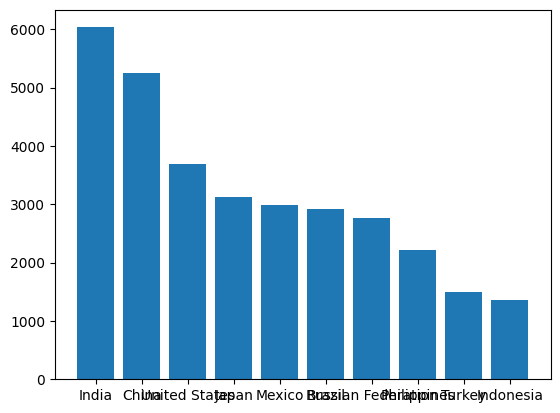

In [51]:
plt.bar(top_df3.country, top_df3.total_revenue)

In [ ]:
# Question 4

query4 = """
    SELECT a.actor_id, a.first_name, a.last_name, SUM(p.amount) AS total_revenue
    FROM actor a
    JOIN film_actor fa ON a.actor_id = fa.actor_id
    JOIN inventory inv ON fa.film_id = inv.film_id
    JOIN rental r ON inv.inventory_id = r.inventory_id
    JOIN payment p ON r.rental_id = p.rental_id
    GROUP BY a.actor_id, a.first_name, a.last_name
    ORDER BY total_revenue DESC
    """

actor_revenue_df = pd.read_sql_query(query4, conn)

In [42]:
actor_revenue_df.head(11)

,actor_id,first_name,last_name,total_revenue
0,107,Gina,Degeneres,3129.17
1,181,Matthew,Carrey,2543.78
2,198,Mary,Keitel,2426.92
3,81,Scarlett,Damon,2403.81
4,102,Walter,Torn,2403.18
5,60,Henry,Berry,2392.36
6,58,Christian,Akroyd,2378.97
7,144,Angela,Witherspoon,2357.11
8,111,Cameron,Zellweger,2322.94
9,28,Woody,Hoffman,2315.92


In [80]:
# Questions 5 & 6

# Create a DataFrame with country classifications
countries_classification = pd.DataFrame({
    "country": ["United States", "Canada", "United Kingdom", "Germany", "France", "Japan", "India", "Morocco", "Zambia", "Nicaragua"],
    "classification": ["High Income", "High Income", "High Income", "High Income", "High Income", "High Income", "Medium Income", "Medium Income", "Low Income", "Low Income"]
})


In [ ]:
# Query the data for countries
query = """
    SELECT country_id, country
    FROM country
"""

countries_df = pd.read_sql_query(query, conn)

# Merge the two DataFrames based on country name
merged_df = pd.merge(countries_df, countries_classification, on="country")

In [83]:
merged_df.head(10)

,country_id,country,classification
0,20,Canada,High Income
1,34,France,High Income
2,38,Germany,High Income
3,44,India,Medium Income
4,50,Japan,High Income
5,62,Morocco,Medium Income
6,102,United Kingdom,High Income
7,103,United States,High Income
8,109,Zambia,Low Income


In [ ]:
# Close the database connection
conn.close()